# Emotion Recognition On Audio - CNN Model

## Importing needed libraries

In [103]:
!pip install tensorflow-addons
!pip install sentencepiece
!pip install tensorflow_hub
!pip install transformers
!pip install pytest


# System Libraries
import os
from pathlib import Path
import tarfile
from IPython.display import Audio, clear_output

# Handling Data Libraries
import pandas as pd
import numpy as np
import sentencepiece
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Plot Libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Transformer models Libraries and utilities, metrics
from sklearn.metrics import classification_report, f1_score
from keras.utils.data_utils import get_file
from keras.utils.data_utils import get_file
from transformers import AlbertTokenizer, TFAlbertModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
import tensorflow_hub as hub
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

# Download of the chosen model and its tokenizer
print('Using TensorFlow version', tf.__version__)
tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")
albert = TFAlbertModel.from_pretrained("albert-base-v2")


random_seed = 42

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Using TensorFlow version 2.12.0


Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


## Preprocessing

### Dataset download

In [104]:
from google.colab import files

def download_dataset_from_kaggle_to_colab():
    files.upload()
    !ls -lha kaggle.json
    !pip install -q kaggle # Install kaggle API
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d riccardopaolini/nlp-project-work
    !unzip nlp-project-work.zip
    clear_output()

download_dataset_from_kaggle_to_colab()

### Dataset conversion into table

In [105]:
def build_IEMOCAP_dataframe():
    folder = os.path.join(os.getcwd(), 'IEMOCAP/IEMOCAP')

    conv_id = 0

    df = []
    for session in os.listdir(folder):
        session_path = os.path.join(folder, session)
        # 'dialogue' folder contains Emotions and Transcripts
        # 'sentences' folder contains Audios

        trans_folder = os.path.join(session_path, 'dialog', 'transcriptions')

        for trans_name in os.listdir(trans_folder):
            if trans_name[:2] != '._':
                emo_path = os.path.join(session_path, 'dialog', 'EmoEvaluation', trans_name)
                with open(os.path.join(trans_folder, trans_name), encoding='utf8') as trans_file, open(emo_path, encoding='utf8') as emo_file:
                    conv_id += 1
                    turn_id = 0
                    for line in trans_file:
                        #print(line.split('_'))
                        audio_name, text = line.split(':')
                        if trans_name.split('.')[0] in audio_name:
                            turn_id += 1

                            wav_path = os.path.join(session_path, 'sentences', 'wav', trans_name.split('.')[0], audio_name.split(' ')[0] + '.wav')

                            reached = False
                            count_em = {'Anger': 0, 'Happiness': 0, 'Sadness': 0, 'Neutral': 0, 'Frustration': 0, 'Excited': 0, 'Fear': 0, 'Surprise': 0, 'Disgust': 0, 'Other': 0}
                            for emo_line in emo_file:
                                if audio_name.split(' ')[0] in emo_line:
                                    emotion, vad = emo_line.split('\t')[-2:]
                                    vad = vad[1:-2].split(',')
                                    reached = True
                                elif emo_line[0] == 'C' and reached:
                                    evaluator = emo_line.split(':')[0]
                                    emotions = emo_line.split(':')[1].split('(')[0].split(';')
                                    emotions = [em.strip() for em in emotions]
                                    for em in emotions:
                                        if em != '':
                                            count_em[em] += 1
                                elif reached:
                                    emo_file.seek(0)
                                    break
                                        

                            row = {'conv_id': conv_id, 
                                    'turn_id': turn_id, 
                                    'sentence': text.strip(),
                                    'path': wav_path,
                                    'emotion': emotion,
                                    'valence': float(vad[0]),
                                    'activation': float(vad[1]),
                                    'dominance': float(vad[2])
                                    }
                            
                            df.append(dict(**row, **count_em))

    return pd.DataFrame(df)

df = build_IEMOCAP_dataframe()
df.head()

,conv_id,turn_id,sentence,path,emotion,valence,activation,dominance,Anger,Happiness,Sadness,Neutral,Frustration,Excited,Fear,Surprise,Disgust,Other
0,1,1,"How's it going, babe?",/content/IEMOCAP/IEMOCAP/Session3/sentences/wa...,neu,4.0,2.5,1.0,0,0,0,2,0,1,0,0,0,1
1,1,2,Yeah?,/content/IEMOCAP/IEMOCAP/Session3/sentences/wa...,neu,3.5,2.0,1.0,0,0,0,2,0,1,0,0,0,1
2,1,3,All right.,/content/IEMOCAP/IEMOCAP/Session3/sentences/wa...,neu,2.5,2.0,2.0,0,0,0,3,1,0,0,0,0,0
3,1,4,Good.,/content/IEMOCAP/IEMOCAP/Session3/sentences/wa...,xxx,3.0,1.5,1.0,0,0,1,1,0,1,0,0,0,1
4,1,5,"Hey listen,eh- I've been wanting to talk to yo...",/content/IEMOCAP/IEMOCAP/Session3/sentences/wa...,xxx,3.5,3.0,1.0,0,0,1,1,0,1,1,0,0,1


### Dataset inspection

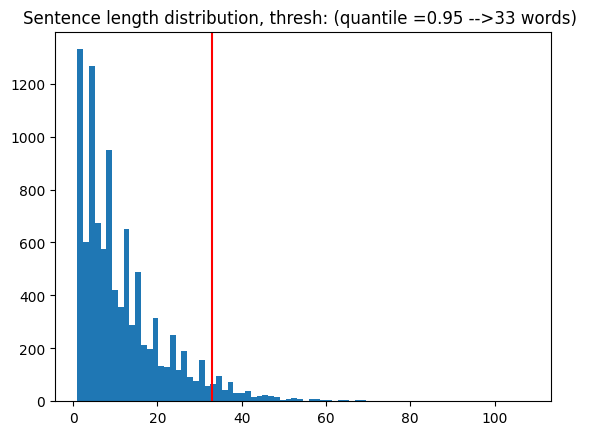

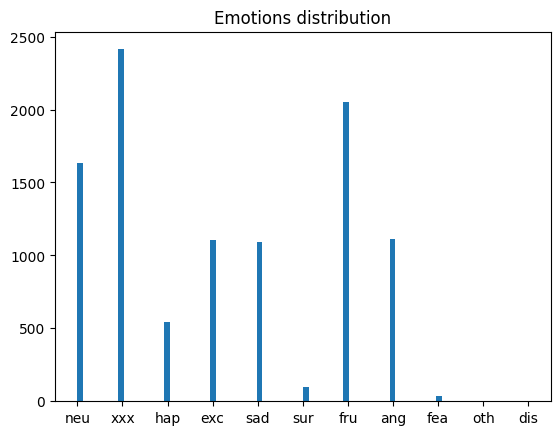

In [109]:
X = df["sentence"].copy()
y = df["emotion"].copy()


# drawing plot of the sentences length distribution

lengths = [len(t.split(' ')) for t in X]
quantile = 0.95
thresh = int(np.quantile(lengths, quantile))
plt.hist(lengths, bins = len(set(lengths)))
plt.title(f"Sentence length distribution, thresh: (quantile ={quantile} -->{thresh} words) ")
plt.axvline(x = thresh, color = 'r', label = 'axvline - full height')
plt.show()

# drawing plot of the emotions distribution
plt.hist(y, bins = len(set(lengths)))
plt.title("Emotions distribution")
plt.show()

### Dataset split

In [110]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_seed)# stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=random_seed)

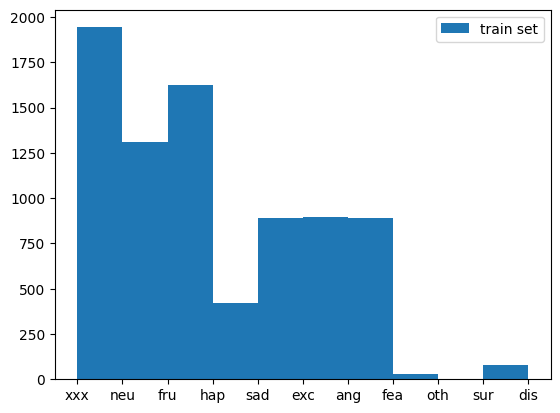

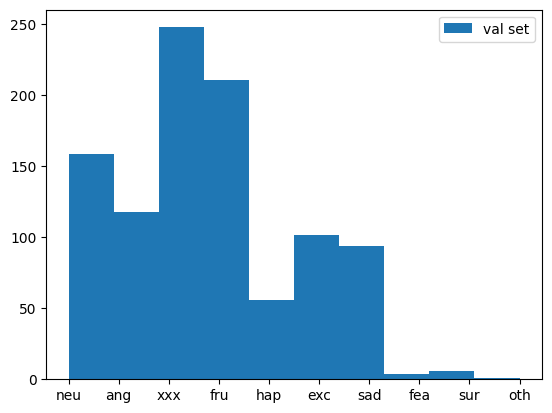

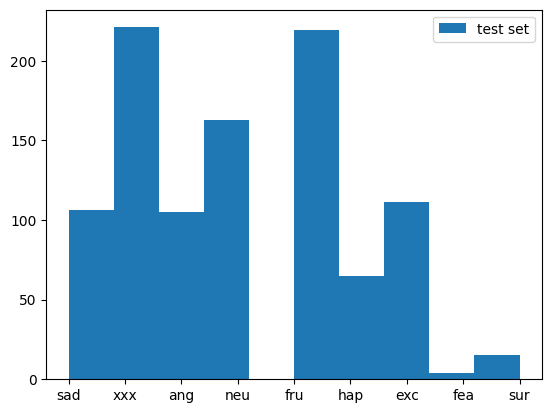

In [111]:
plt.hist(y_train, label="train set")
plt.legend()
plt.show()
plt.hist(y_val, label = "val set")
plt.legend()
plt.show()
plt.hist(y_test, label = "test set")
plt.legend()
plt.show()

## ALBERT

### Tokenization

In [7]:
# setting length cut-limit for the sentences
maxlen = thresh

x_train_albert = tokenizer(
    text = X_train.tolist(),
    add_special_tokens=True,
    max_length = maxlen,
    truncation = True,
    padding = 'max_length',
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

x_val_albert = tokenizer(
    text = X_val.tolist(),
    add_special_tokens=True,
    max_length = maxlen,
    truncation = True,
    padding = 'max_length',
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)

x_test_albert = tokenizer(
    text = X_test.tolist(),
    add_special_tokens=True,
    max_length = maxlen,
    truncation = True,
    padding = "max_length",
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)
     

### One-hot encoding of labels

In [8]:
encoded_dict= {'ang':0, 'dis':1, 'exc':2, 'fea':3, 'fru':4, 'hap':5,'neu':6, 'oth':7, 'sad':8, 'sur':9, 'xxx':10}

y_train_albert = y_train.map(encoded_dict)

y_test_albert = y_test.map(encoded_dict)

y_val_albert = y_val.map(encoded_dict)

print("Before one-hot encoding: \n")
print(y_train)
print("Label count by class: \n")
print(np.unique(y_train,return_counts=True))

print("After one-hot encoding: \n")
print(y_train_albert) 
print("Label count by class: \n")
print(np.unique(y_train_albert,return_counts=True))


# testing if the label vector has still same dimension
assert len(y_train) == len(y_train_albert)
assert len(y_val) == len(y_val_albert)
assert len(y_test) == len(y_test_albert)

# checking if new vectors contain only integers
assert np.array_equal(y_train_albert, y_train_albert.astype(int))
assert np.array_equal(y_val_albert, y_val_albert.astype(int))
assert np.array_equal(y_test_albert, y_test_albert.astype(int))


Before one-hot encoding: 

3833    xxx
8973    neu
994     fru
5324    fru
8403    hap
       ... 
9172    xxx
8558    neu
7465    xxx
9226    hap
7426    neu
Name: emotion, Length: 8079, dtype: object
Label count by class: 

(array(['ang', 'dis', 'exc', 'fea', 'fru', 'hap', 'neu', 'oth', 'sad',
       'sur', 'xxx'], dtype=object), array([ 888,    1,  895,   27, 1623,  420, 1312,    2,  889,   78, 1944]))
After one-hot encoding: 

3833    10
8973     6
994      4
5324     4
8403     5
        ..
9172    10
8558     6
7465    10
9226     5
7426     6
Name: emotion, Length: 8079, dtype: int64
Label count by class: 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([ 888,    1,  895,   27, 1623,  420, 1312,    2,  889,   78, 1944]))


### Model definition

In [9]:
# input
input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")
# pretrained 
embeddings = albert([input_ids, input_mask])[0] #(0 is the last hidden layer, 1 means pooler output)
# last layers and output
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation = 'relu')(out)
y = Dense(11, activation = 'Softmax')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs = y)
model.layers[2].trainable = True

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 33)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 33)]         0           []                               
                                                                                                  
 tf_albert_model (TFAlbertModel  TFBaseModelOutputWi  11683584   ['input_ids[0][0]',              
 )                              thPooling(last_hidd               'attention_mask[0][0]']         
                                en_state=(None, 33,                                               
                                 768),                                                        

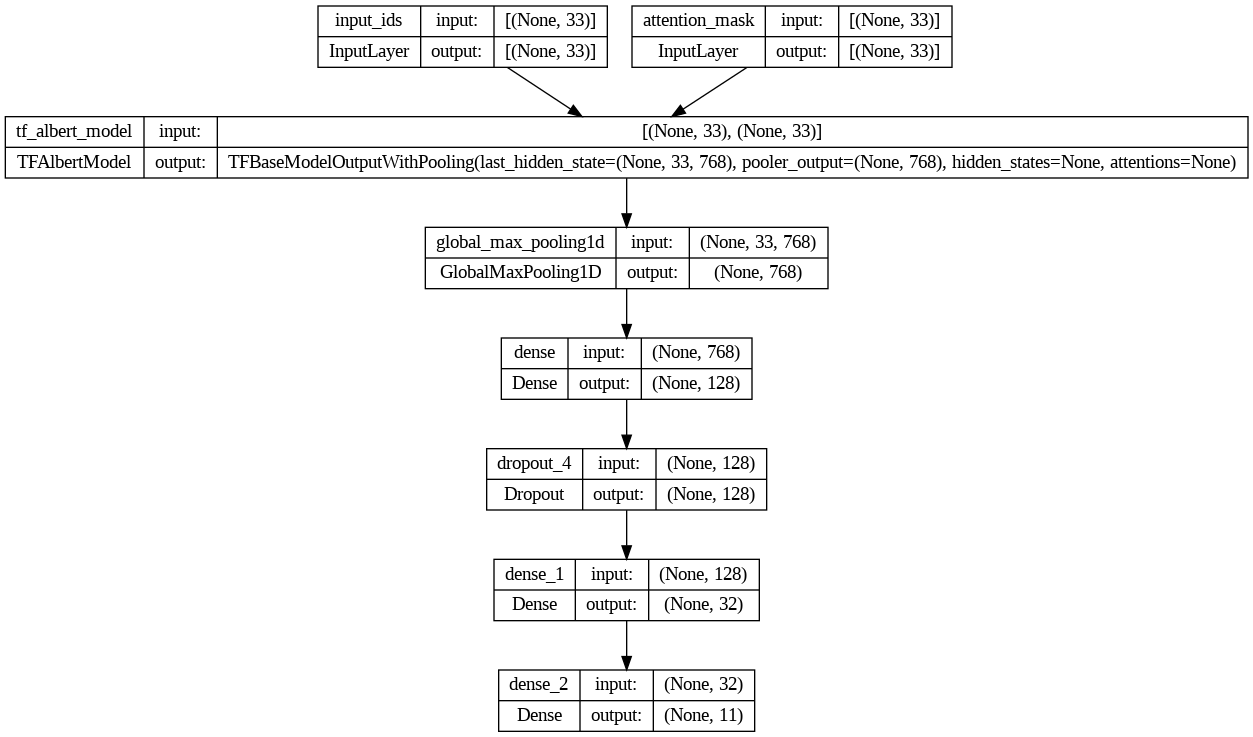

In [11]:
tf.keras.utils.plot_model(model,show_shapes=True)

### Model training

In [12]:
# utility to plot train history
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(range(1, len(model_history.history[m])+1), model_history.history[m])
    plt.plot(range(1, len(model_history.history[val_m])+1),model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

#### Training settings

In [13]:
optimizer=Adam(
    learning_rate = 1e-05, # this learning rate is for bert model, taken from hugging face site
)

# set loss and metrics 
loss = 'categorical_crossentropy'#CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy(name='balanced_accuracy',dtype='float32')
f1 = tfa.metrics.F1Score(num_classes=11,average='macro')

# compile the model
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = [metric,f1]
)

#### Training

In [14]:
albert_history = model.fit(
    x = {'input_ids': x_train_albert['input_ids'],'attention_mask':x_train_albert['attention_mask']},
    y = to_categorical(y_train_albert),
    validation_data = ({'input_ids':x_val_albert['input_ids'],'attention_mask':x_val_albert['attention_mask']}, to_categorical(y_val_albert)),
    epochs=7, 
    batch_size=80,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=2, verbose=1, mode='max', restore_best_weights=True)]
)

Epoch 1/7


 23/101 [=====>........................] - ETA: 37:19 - loss: 2.9418 - balanced_accuracy: 0.1103 - f1_score: 0.0549

KeyboardInterrupt: ignored

In [ ]:
plot_history(albert_history,['f1_score','val_f1_score'])

### Testing

In [ ]:
y_pred_albert = model.predict({'input_ids':x_test_albert['input_ids'],'attention_mask':x_test_albert['attention_mask']})
# convertion of the guessed label in integer labels
y_pred_albert = np.argmax(y_pred_albert, axis = 1)

f1_macro = f1_score(y_test_albert,y_pred_albert, average='macro')

print("The final F1-score macro avg obtained on the test set is F1 = {}".format(f1_macro))

In [ ]:
print(classification_report(y_test_albert,y_pred_albert))

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_albert,y_pred_albert)

## Bi-LSTM

In [293]:
!pip install text_hammer
import text_hammer as th
import re
tf.random.set_seed(random_seed)

def text_lite_preprocessing(data, col_name):
  column = col_name
  df = data.copy().to_frame()
  df[column] = df[column].progress_apply(lambda x: str(x).lower())
  df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) # you're --> you are
  df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
  df[column] = df[column].progress_apply(lambda x: re.sub(r'\d', "number", x))
  df[column] = df[column].progress_apply(lambda x: re.sub("_", "number", x))
  return (df)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [294]:
train_clean_litemodel = text_lite_preprocessing(X_train, "sentence")
test_clean_litemodel = text_lite_preprocessing(X_test, "sentence")
val_clean_litemodel = text_lite_preprocessing(X_val, "sentence")

  0%|          | 0/8079 [00:00<?, ?it/s]

  0%|          | 0/8079 [00:00<?, ?it/s]

  0%|          | 0/8079 [00:00<?, ?it/s]

  0%|          | 0/8079 [00:00<?, ?it/s]

  0%|          | 0/8079 [00:00<?, ?it/s]

  0%|          | 0/8079 [00:00<?, ?it/s]

  0%|          | 0/1009 [00:00<?, ?it/s]

  0%|          | 0/1009 [00:00<?, ?it/s]

  0%|          | 0/1009 [00:00<?, ?it/s]

  0%|          | 0/1009 [00:00<?, ?it/s]

  0%|          | 0/1009 [00:00<?, ?it/s]

  0%|          | 0/1009 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

In [295]:
print(train_clean_litemodel)

                                               sentence
3833                         well you help me stay here
8973                                          yeah yeah
994   and so i am getting the animals putting the an...
5324  and i got to i got to work here all day long o...
8403                        with the most perfect poise
...                                                 ...
9172  it is just fish i mean nothing to get traumati...
8558                           you cannot read her mind
7465                     we were very much younger then
9226  i do not know it seemed like a pretty good spo...
7426  youre a considerate fellow there is nothing wr...

[8079 rows x 1 columns]


### Tokenization

In [296]:
from tensorflow.keras.preprocessing.text import Tokenizer
# creating tokenizer and fitting it on the training test
tokenizer = Tokenizer(num_words = None, oov_token='', split=' ', lower=False)
tokenizer.fit_on_texts(X)
print(tokenizer.get_config())


# printing a tokenization example
print("## Before tokenization: ")
print(train_clean_litemodel.iloc[2])
print("## After tokenization: ")
print(tokenizer.texts_to_sequences(train_clean_litemodel.sentence)[2])

{'num_words': None, 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 'lower': False, 'split': ' ', 'char_level': False, 'oov_token': '', 'document_count': 10087, 'word_counts': '{"How\'s": 13, "it": 1799, "going": 700, "babe": 6, "Yeah": 490, "All": 145, "right": 519, "Good": 25, "Hey": 45, "listen": 35, "eh": 2, "I\'ve": 207, "been": 255, "wanting": 1, "to": 3245, "talk": 77, "you": 4209, "I": 5578, "have": 954, "something": 245, "tell": 157, "Amy": 3, "doing": 121, "She\'s": 57, "fine": 62, "She": 71, "just": 1044, "took": 47, "her": 242, "first": 96, "steps": 3, "today": 28, "actually": 55, "videotaped": 1, "for": 785, "so": 613, "can": 548, "watch": 8, "yeah": 181, "oh": 72, "really": 287, "want": 660, "say": 145, "that": 1796, "Well": 616, "know": 1716, "at": 432, "the": 2377, "center": 8, "department": 7, "they": 419, "called": 14, "me": 1004, "in": 967, "and": 1968, "talked": 8, "Oh": 500, "What": 554, "did": 248, "umm": 6, "was": 696, "promoted": 3, "wow": 9, "That\'s": 253, 

In [297]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, dataset, maxlen):
  sequences = tokenizer.texts_to_sequences(dataset)
  print(sequences)
  padded = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen= maxlen)
  return padded



In [298]:
padded_train_seq = get_sequences(tokenizer, train_clean_litemodel.sentence, maxlen=thresh)
padded_val_seq = get_sequences(tokenizer, val_clean_litemodel.sentence, maxlen=thresh)
padded_test_seq = get_sequences(tokenizer, test_clean_litemodel.sentence, maxlen=thresh)

[[170, 3, 140, 16, 231, 50], [114, 114], [7, 35, 1555, 121, 260, 5, 970, 705, 5, 970, 43, 19, 5, 936, 1555, 121, 705, 36, 31, 495, 260, 5, 317, 43, 11, 5, 1097], [7, 1555, 56, 4, 1555, 56, 4, 151, 50, 37, 213, 103, 149, 1555, 20, 56, 4, 485, 44, 3, 113, 37, 213], [44, 5, 545, 880, 1251], [1838, 27, 3, 20, 50, 14, 1190, 7, 66, 14, 816, 36, 8], [154, 1555, 21, 23, 10, 147], [1, 173, 100, 6, 1215, 720], [1555, 40, 63, 9], [60, 28, 318, 61, 5, 263, 94], [5, 158, 5, 158, 234, 23, 1113, 16], [1555, 702, 140, 8, 1555, 10, 88, 269, 1555, 26, 1120, 343, 684, 4, 88, 31, 181, 199, 240, 138, 107, 1555, 57, 11, 6, 915, 1555, 57, 11, 1], [8, 30, 6, 159, 11, 815, 189, 24, 189, 3, 145, 16], [58, 58, 58], [35, 1, 13, 5, 319, 514, 1374], [22, 1, 22, 22, 14, 23, 131, 486, 211, 340, 36, 5, 265, 974, 7, 209], [264, 24, 93, 146], [27, 55, 3, 21, 23, 122, 78], [7, 1555, 100, 22, 360, 74, 1555, 30, 699, 83, 46, 178, 13, 161, 30, 258, 941, 3, 10, 48, 1555, 457, 13, 22, 68, 190, 94, 30, 258, 377, 3, 10, 8, 14, 

### One-hot encoding of labels

In [299]:
class_to_index = {'ang':0, 'dis':1, 'exc':2, 'fea':3, 'fru':4, 'hap':5,'neu':6, 'oth':7, 'sad':8, 'sur':9, 'xxx':10}

names_to_ids = lambda labels_to_conv: np.array([class_to_index.get(x) for x in labels_to_conv])

y_train_litemodel = names_to_ids(y_train)
y_val_litemodel = names_to_ids(y_val)
y_test_litemodel =  names_to_ids(y_test)

print(len(y_train_litemodel))

8079


### Model definition

In [300]:

model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(tokenizer.document_count, 64, input_length=thresh),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(11,activation='Softmax')
        
])


In [301]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 33, 64)            645568    
                                                                 
 bidirectional_40 (Bidirecti  (None, 33, 128)          66048     
 onal)                                                           
                                                                 
 bidirectional_41 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                                 
 dense_23 (Dense)            (None, 11)                1419      
                                                                 
Total params: 811,851
Trainable params: 811,851
Non-trainable params: 0
_________________________________________________________________


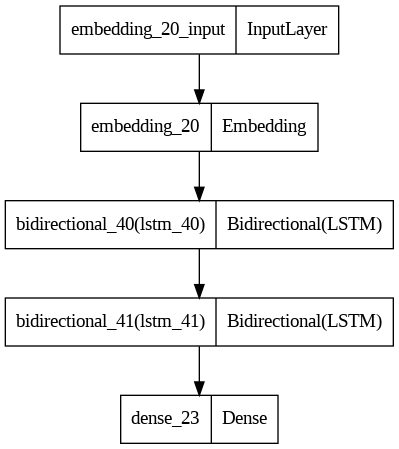

In [302]:
tf.keras.utils.plot_model(model)

### Model training

In [303]:
# utility to plot train history
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(range(1, len(model_history.history[m])+1), model_history.history[m])
    plt.plot(range(1, len(model_history.history[val_m])+1),model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

#### Training settings

In [304]:
f1 = tfa.metrics.F1Score(num_classes=11,average='macro')
accuracy = 'accuracy'

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=5e-3),
    metrics = [accuracy,f1]
)

#### Training

In [305]:
bilstm_history = model.fit(
    padded_train_seq, to_categorical(y_train_litemodel),
    validation_data=(padded_val_seq, to_categorical(y_val_litemodel)),
    epochs =15,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_f1_score', patience=3, verbose=1, mode='max', restore_best_weights=True)],
    batch_size=70
)

Epoch 1/15
116/116 [==============================] - 63s 404ms/step - loss: 1.8567 - accuracy: 0.2753 - f1_score: 0.1196 - val_loss: 1.6877 - val_accuracy: 0.3413 - val_f1_score: 0.1945
Epoch 2/15
116/116 [==============================] - 36s 313ms/step - loss: 1.5785 - accuracy: 0.4085 - f1_score: 0.2313 - val_loss: 1.6048 - val_accuracy: 0.3874 - val_f1_score: 0.2128
Epoch 3/15
116/116 [==============================] - 22s 192ms/step - loss: 1.4138 - accuracy: 0.4752 - f1_score: 0.2823 - val_loss: 1.5913 - val_accuracy: 0.4064 - val_f1_score: 0.2333
Epoch 4/15
116/116 [==============================] - 21s 180ms/step - loss: 1.3044 - accuracy: 0.5209 - f1_score: 0.3206 - val_loss: 1.5888 - val_accuracy: 0.4164 - val_f1_score: 0.2496
Epoch 5/15
116/116 [==============================] - 22s 193ms/step - loss: 1.2013 - accuracy: 0.5563 - f1_score: 0.3489 - val_loss: 1.6442 - val_accuracy: 0.4064 - val_f1_score: 0.2485
Epoch 6/15
116/116 [==============================] - 21s 178ms/s

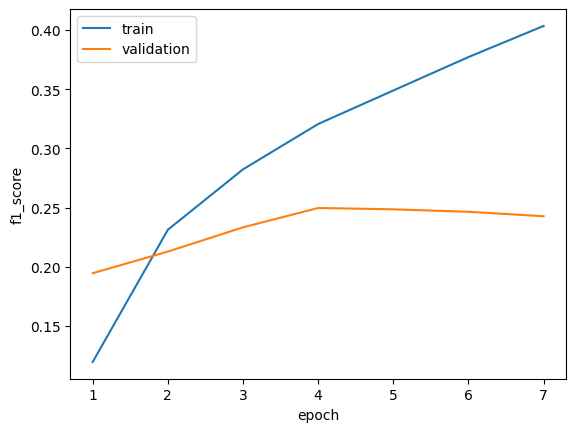

In [306]:
plot_history(bilstm_history,['f1_score','val_f1_score'])

### Testing

In [307]:
y_pred_litemodel = model.predict(padded_test_seq)
# convertion of the guessed label in integer labels
y_pred_litemodel = np.argmax(y_pred_litemodel, axis = 1)

32/32 [==============================] - 3s 38ms/step


In [308]:
f1_macro = f1_score(y_test_litemodel,y_pred_litemodel, average='macro')

print("The final F1-score macro avg obtained on the test set is F1 = {}".format(f1_macro))

The final F1-score macro avg obtained on the test set is F1 = 0.3129173980596635


In [309]:
from sklearn.metrics import classification_report

print(classification_report(y_test_litemodel,y_pred_litemodel))
     

              precision    recall  f1-score   support

           0       0.56      0.37      0.45       105
           2       0.56      0.34      0.42       111
           3       0.00      0.00      0.00         4
           4       0.50      0.47      0.48       219
           5       0.50      0.17      0.25        65
           6       0.34      0.40      0.37       163
           8       0.40      0.51      0.45       106
           9       0.00      0.00      0.00        15
          10       0.33      0.48      0.39       221

    accuracy                           0.41      1009
   macro avg       0.35      0.30      0.31      1009
weighted avg       0.43      0.41      0.41      1009



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [310]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_litemodel,y_pred_litemodel)

0.41129831516352827